# Week 11 — Representation Learning (CNNs)

This notebook explores convolutional networks and learned representations. You'll:
- Build CNNs and understand receptive fields
- Visualize filters and activations
- Apply transfer learning with pretrained models
- Conduct ablation studies

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0+cpu


In [ ]:

import os, pickle
import torch

CACHE_DIR = "cache_week15"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

def save_model(model, name):
    """Save model weights to cache dir."""
    torch.save(model.state_dict(), os.path.join(CACHE_DIR, f"{name}.pth"))

def load_model_state(name):
    """Return state_dict if cached, else None."""
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    return torch.load(path, weights_only=True) if os.path.exists(path) else None

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week11


## 1. Build a Small CNN

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=10)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

Total parameters: 421642


## 2. Load MNIST and Train

In [4]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64, shuffle=False)

MODEL_KEY = "cnn_mnist_5epochs"
model = SimpleCNN()

state = load_model_state(MODEL_KEY)
if state is not None:
    model.load_state_dict(state)
    print(f"[cache] Loaded trained CNN weights from {MODEL_KEY}.pth")
    # Evaluate
    model.eval()
    correct = sum(model(d).argmax(dim=1).eq(t).sum().item()
                  for d, t in test_loader)
    accuracy = 100. * correct / len(test_dataset)
    print(f"Test Accuracy (cached): {accuracy:.2f}%")
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print("[cache] Training CNN from scratch (will be cached afterwards)...")
    for epoch in range(5):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 200 == 0:
                print(f"  Epoch {epoch+1}/5, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
    model.eval()
    correct = sum(model(d).argmax(dim=1).eq(t).sum().item() for d, t in test_loader)
    accuracy = 100. * correct / len(test_dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")
    save_model(model, MODEL_KEY)
    print(f"[cache] Saved to {MODEL_KEY}.pth")


[cache] Loaded trained CNN weights from cnn_mnist_5epochs.pth
Test Accuracy (cached): 99.05%


## 3. Visualize Filters and Activations

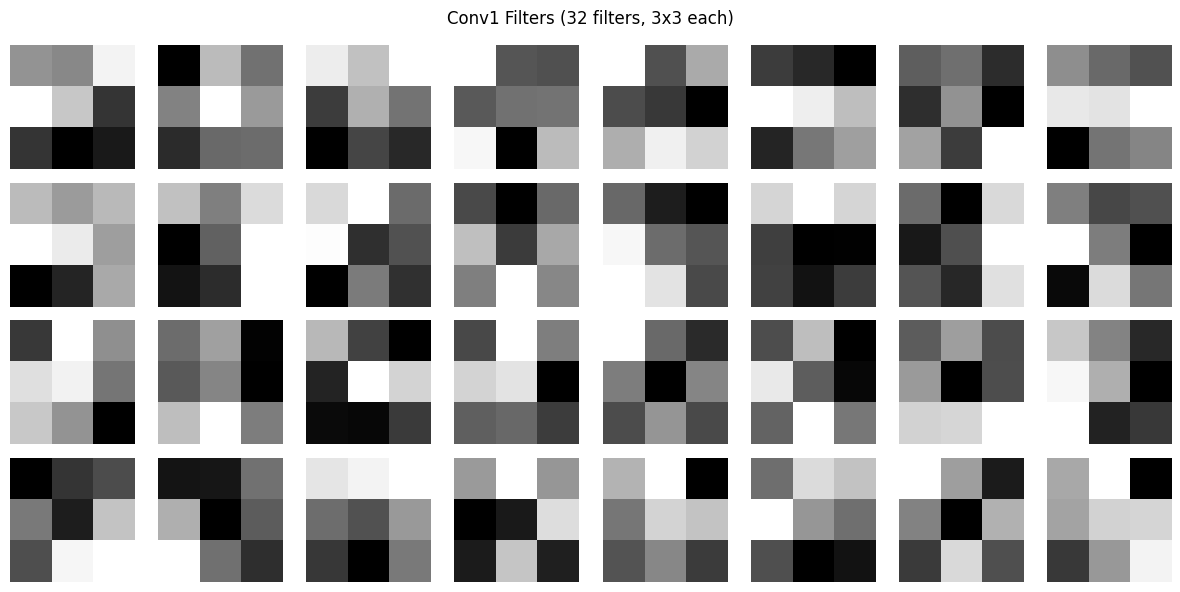

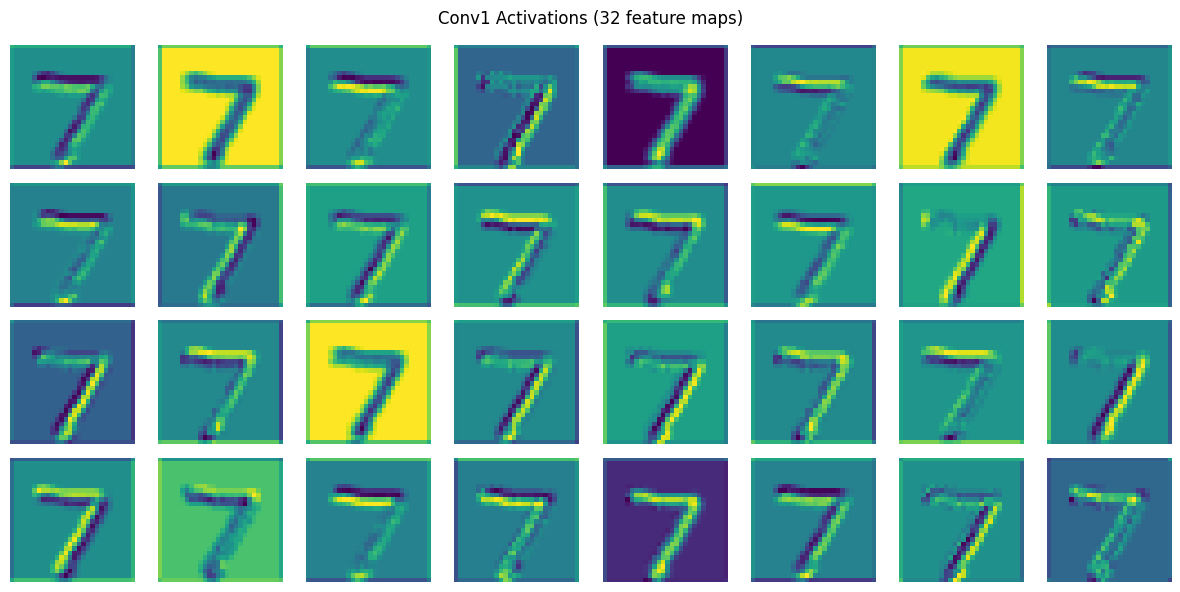

In [5]:
# Visualize first conv layer filters
filters = model.conv1.weight.data.cpu().numpy()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:
        ax.imshow(filters[i, 0], cmap='gray')
        ax.axis('off')
plt.suptitle('Conv1 Filters (32 filters, 3x3 each)')
plt.tight_layout()
plt.show()

# Capture activations using hooks
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Get a sample image
sample_img, _ = test_dataset[0]
sample_img = sample_img.unsqueeze(0)
_ = model(sample_img)

# Visualize activations
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
conv1_act = activations['conv1'][0].cpu().numpy()
for i, ax in enumerate(axes.flat):
    if i < conv1_act.shape[0]:
        ax.imshow(conv1_act[i], cmap='viridis')
        ax.axis('off')
plt.suptitle('Conv1 Activations (32 feature maps)')
plt.tight_layout()
plt.show()

## 4. Transfer Learning with Pretrained Model

In [11]:
# Load pretrained ResNet18 (for demonstration)
pretrained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 10)

print("Pretrained ResNet18 adapted for MNIST (10 classes)")
print(f"Trainable parameters: {sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)}")
print(f"Total parameters: {sum(p.numel() for p in pretrained_model.parameters())}")

Pretrained ResNet18 adapted for MNIST (10 classes)
Trainable parameters: 5130
Total parameters: 11181642


## Exercises

1. **Deeper CNNs**: Build a 5-layer CNN and compare to the 2-layer version
2. **Receptive Fields**: Calculate and visualize receptive field sizes
3. **Feature Extraction**: Extract features from a pretrained model and train a classifier
4. **Ablation Study**: Vary depth/width and document effects on accuracy

## Deliverables

- [ ] CNN implementation and training on MNIST/CIFAR-10
- [ ] Filter and activation visualizations
- [ ] Transfer learning experiment
- [ ] Ablation study report

In [7]:

# EXERCISE 1 — Deeper CNN (5 conv layers)
# Goal: build SimpleCNN5 with 5 conv layers, BatchNorm, and a GlobalAvgPool before FC.
# Train on MNIST (5 epochs, LR=0.001) and compare to SimpleCNN.
# Cache model weights with save_model(..., "cnn_5layer_mnist_5epochs").
# Expected insight: Global Average Pooling drastically reduces parameter count vs FC.


In [8]:

# EXERCISE 2 — Receptive Field Calculation
# Goal: manually compute the receptive field of the last conv layer in SimpleCNN.
# Formula: RF_n = RF_{n-1} + (kernel_size - 1) * stride_product_up_to_n.
# Write the formula as a function receptive_field(layers) and print the RF at each layer.
# Expected insight: every pixel in the last feature map "sees" a specific patch of the input.


In [9]:

# EXERCISE 4 — Feature Extraction with Frozen ResNet18
# Goal: load resnet18(pretrained=True). Freeze all layers. Replace the final FC.
# Train ONLY the new FC layer on MNIST for 3 epochs (resize images to 224×224 or 3ch).
# Compare to training SimpleCNN from scratch: accuracy, training time.
# Cache model with save_model(..., "resnet18_frozen_mnist_3epochs").
# Expected insight: transfer even from ImageNet → MNIST is surprisingly effective.
